In [2]:
import pandas as pd 
import os
import numpy as np
import scipy.linalg as la
import sys
from sklearn.model_selection import KFold # import KFold
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from statsmodels.stats.dist_dependence_measures import distance_correlation
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error, r2_score
from sklearn.kernel_ridge import KernelRidge
from joblib import Parallel, delayed
from lib_cumsir import *

### Data

Data is downloaded from <https://archive.ics.uci.edu/dataset/211/communities+and+crime+unnormalized>

In [15]:
df = pd.read_csv('data/communities+and+crime/CommViolPredUnnormalizedData.txt', header=None)
print(df.shape)

(2215, 147)


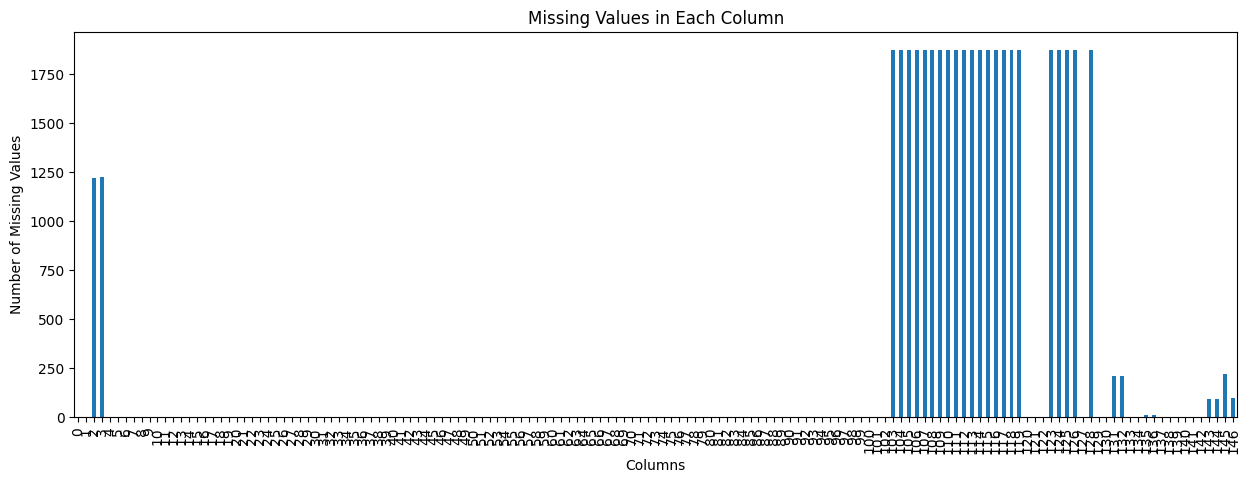

In [4]:
df.replace('?', np.nan, inplace=True)
missing_values = df.isnull().sum()
missing_values.plot(kind='bar', figsize=(15, 5))
plt.xlabel('Columns')
plt.ylabel('Number of Missing Values')
plt.title('Missing Values in Each Column')
plt.show()

In [5]:
observation_counts = df[1].value_counts()
print(observation_counts)

1
CA    279
NJ    211
TX    162
MA    123
OH    111
MI    108
PA    101
FL     90
CT     71
MN     66
WI     60
IN     48
NC     46
NY     46
AL     43
MO     42
WA     40
IL     40
GA     37
OK     36
TN     35
VA     33
OR     31
SC     28
RI     26
KY     26
CO     25
AR     25
UT     24
LA     22
NH     21
IA     20
MS     20
AZ     20
ME     17
WV     14
MD     12
NM     10
SD      9
ND      8
WY      7
ID      7
NV      5
VT      4
AK      3
KS      1
DE      1
DC      1
Name: count, dtype: int64


(2215, 123)


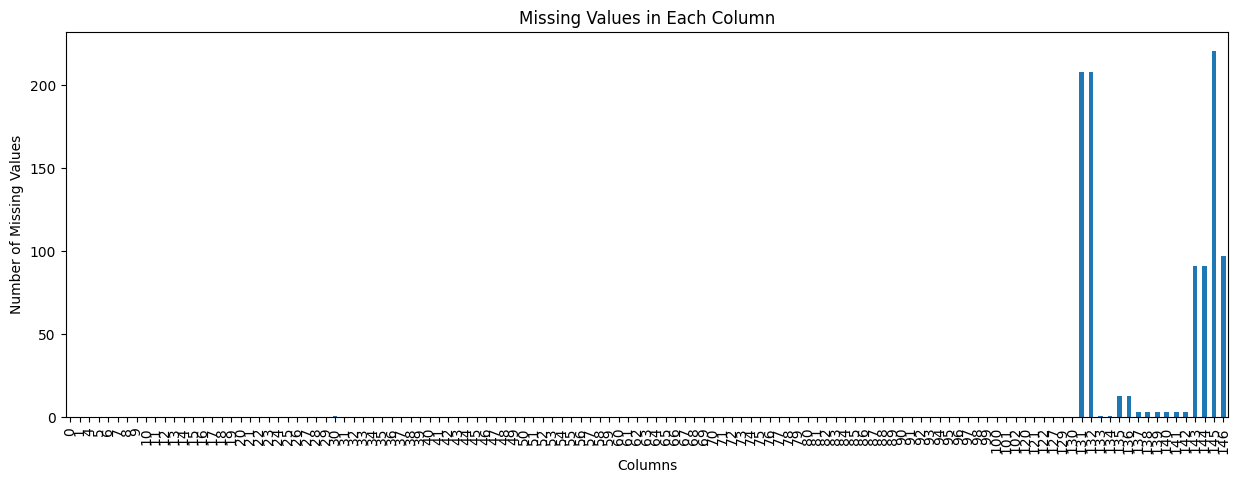

In [6]:
df_cleaned = df.dropna(axis=1, thresh=0.6*df.shape[0])
print(df_cleaned.shape)
missing_values = df_cleaned.isnull().sum()
missing_values.plot(kind='bar', figsize=(15, 5))
plt.xlabel('Columns')
plt.ylabel('Number of Missing Values')
plt.title('Missing Values in Each Column')
plt.show()

In [7]:
df_cleaned2 = df_cleaned.dropna(axis=0)
print(df_cleaned2.shape)
print(df_cleaned2.head())

(1901, 123)
                       0   1    4       5     6     7      8     9     10   \
0  BerkeleyHeightstownship  NJ    1   11980  3.10  1.37  91.78  6.50  1.88   
1           Marpletownship  PA    1   23123  2.82  0.80  95.57  3.44  0.85   
2               Tigardcity  OR    1   29344  2.43  0.74  94.33  3.43  2.35   
5          Springfieldcity  MO    1  140494  2.45  2.51  95.65  0.90  0.95   
6              Norwoodtown  MA    1   28700  2.60  1.60  96.57  1.47  1.10   

     11   ...   137      138   139      140  141     142  143    144     145  \
0  12.47  ...    14   114.85   138  1132.08   16  131.26    2  16.41   41.02   
1  11.01  ...    57   242.37   376  1598.78   26  110.55    1   4.25  127.56   
2  11.36  ...   274   758.14  1797  4972.19  136   376.3   22  60.87  218.59   
5  18.09  ...  2094  1386.46  7690  5091.64  454   300.6  134  88.72  442.95   
6  11.17  ...   110   372.09   288   974.19  144   487.1   17   57.5  226.63   

       146  
0  1394.59  
1  1955.95  

In [77]:
df_TX = df_cleaned[df_cleaned[1]=='TX']
X1 = df_TX.iloc[:,3:105]
Y1 = df_TX.iloc[:,110] ## 110: robberies per 100K, 114: burglaries per 100K
df_CA = df_cleaned2[df_cleaned2[1]=='CA']
X2 = df_CA.iloc[:,3:105]
Y2 = df_CA.iloc[:,110]
print(X1.shape,X2.shape)
print(Y1.shape,Y2.shape)

(162, 102) (278, 102)
(162,) (278,)


In [78]:
print("Missing values in X1:", X1.isnull().sum().sum())
print("Missing values in X2:", X2.isnull().sum().sum())
print("Missing values in Y1:", Y1.isnull().sum())
print("Missing values in Y2:", Y2.isnull().sum())

Missing values in X1: 0
Missing values in X2: 0
Missing values in Y1: 1
Missing values in Y2: 0


In [79]:
# Drop rows with missing values in Y1
non_missing_indices = Y1.dropna().index
X1_cleaned = X1.loc[non_missing_indices]
Y1_cleaned = Y1.loc[non_missing_indices]

# Print the shapes of the cleaned data
print(X1_cleaned.shape)
print(Y1_cleaned.shape)

X = [np.array(X1_cleaned.astype(float)), np.array(X2.astype(float))]
Y = [np.array(Y1_cleaned.astype(float)), np.array(Y2.astype(float))]

(161, 102)
(161,)


In [55]:
df_cleaned.columns[98:106]

Index([100, 101, 102, 120, 121, 122, 127, 129], dtype='int64')

### delete columns

- 104: 120 (17)
- 124: 127 (4)
- 129 (1)

In [80]:
from sklearn.preprocessing import StandardScaler
scaler = StandardScaler()
X_standardized = [scaler.fit_transform(x) for x in X]

In [81]:
X_new = [np.delete(x, [11, 15, 92], axis=0) for x in X_standardized]
Y_new = [np.delete(y, [11,15,92], axis=0) for y in Y]
[print(x.shape) for x in X_new]
[print(y.shape) for y in Y_new]

(158, 102)
(275, 102)
(158,)
(275,)


[None, None]

In [151]:
d = 4
B = comsir_parallel(X_new, Y_new, d, lam_ratio=0.15, max_iter = 100, n_jobs=4)[0]
S = [np.nonzero(la.norm(b, axis = 1))[0] for b in B]
print([len(s) for s in S])

[30, 30]


In [152]:
column_names = df_cleaned2.columns[S[0]+3]
print(column_names+1)

Index([  8,   9,  16,  17,  20,  21,  29,  46,  47,  49,  50,  52,  54,  56,
        60,  61,  63,  64,  65,  66,  68,  75,  79,  82,  96,  99, 100, 121,
       122, 128],
      dtype='int64')


8:  racepctblack: percentage of population that is african american
9: racePctWhite: percentage of population that is caucasian
16: number of people living in areas classified as urban
17: pctUrban: percentage of people living in areas classified as urban 
20: pctWFarmSelf: percentage of households with farm or self employment income in 1989
21: pctWInvInc: percentage of households with investment / rent income in 1989 
29: indianPerCap: per capita income for native americans 
46: FemalePctDiv: percentage of females who are divorced 
47: TotalPctDiv: percentage of population who are divorced
49: PctFam2Par: percentage of families (with kids) that are headed by two parents 
50: PctKids2Par: percentage of kids in family housing with two parents 
52: PctTeen2Par: percent of kids age 12-17 in two parent households
54: PctWorkMom: percentage of moms of kids under 18 in labor force
56: PctKidsBornNeverMar: percentage of kids born to never married
60: PctImmigRec8: percentage of _immigrants_ who immigated within last 8 years 
61: PctImmigRec10: percentage of _immigrants_ who immigated within last 10 years
63: PctRecImmig5: percent of _population_ who have immigrated within the last 5 years
64: PctRecImmig8: percent of _population_ who have immigrated within the last 8 years 
65: PctRecImmig10: percent of _population_ who have immigrated within the last 10 years
66: PctSpeakEnglOnly: percent of people who speak only English 
68: PctLargHouseFam: percent of family households that are large (6 or more) 
75: PctHousLess3BR: percent of housing units with less than 3 bedrooms 
79: PctHousOwnOcc: percent of households owner occupied
82: MedYrHousBuilt: median year housing units built 
96: MedOwnCostPctIncNoMtg: median owners cost as a percentage of household income - for owners without a mortgage
99: PctForeignBorn: percent of people foreign born
100: PctBornSameState: percent of people born in the same state as currently living 
121: LandArea: land area in square miles
122: PopDens: population density in persons per square mile
128: LemasPctOfficDrugUn: percent of officers assigned to drug units

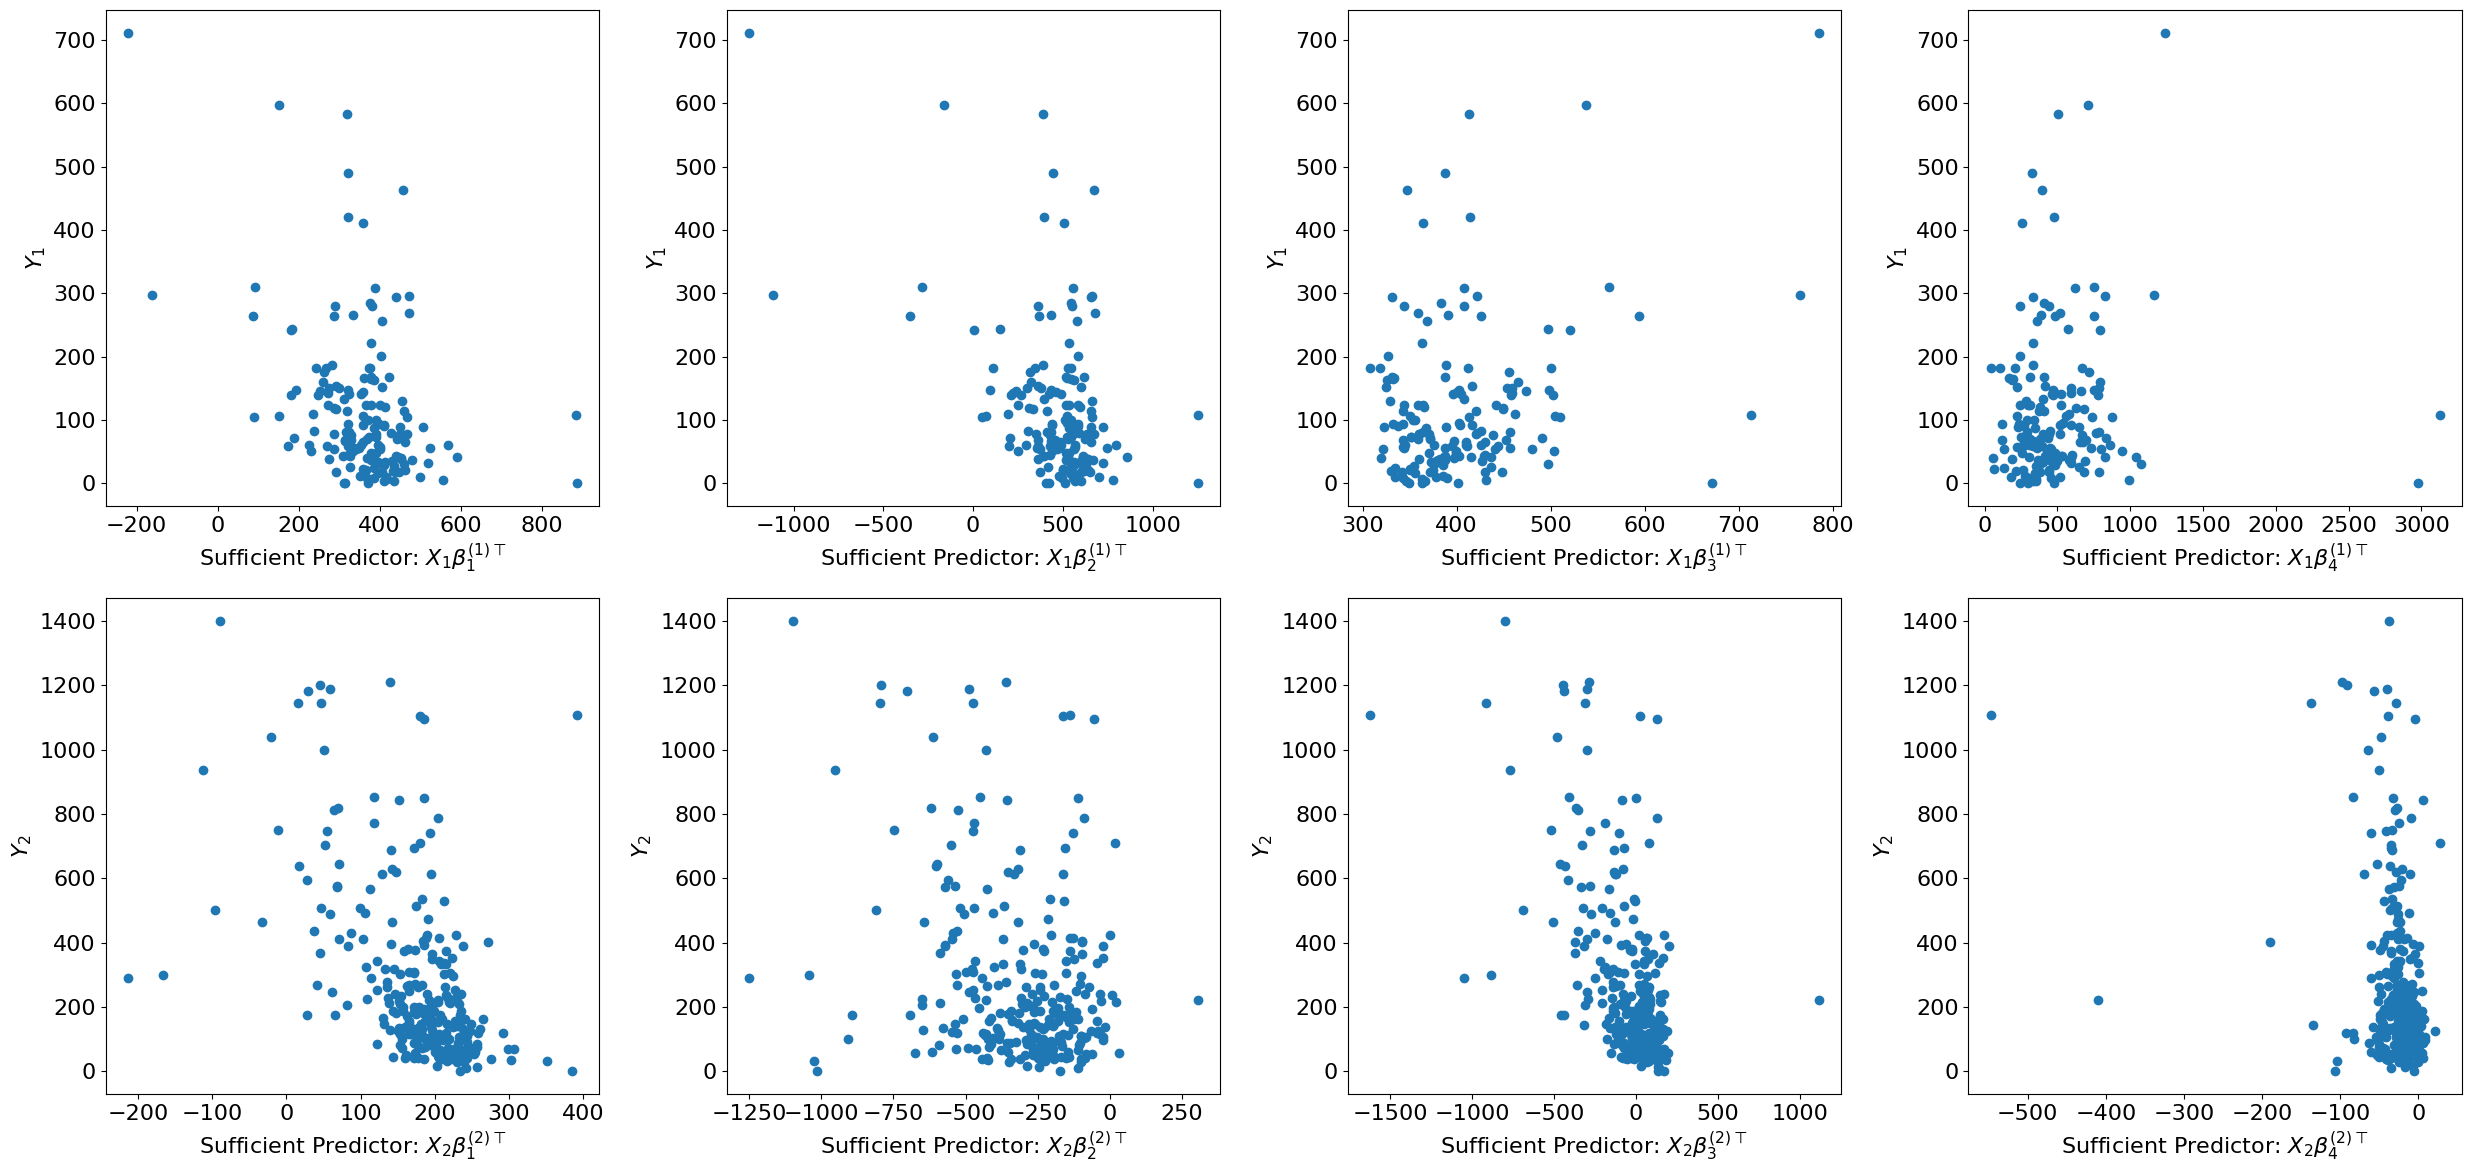

In [158]:
xb = [x @ b for x,b in zip(X,B)]
plt.rcParams.update({'font.size': 16})
fig, axs = plt.subplots(len(Y), d, figsize=(25, 12))
for i, (x, y) in enumerate(zip(xb, Y)):
    for j in range(x.shape[1]):
        row, col = divmod(j, 4)
        axs[row+i, col].scatter(x[:, j], y)
        axs[row+i, col].set_xlabel(r'Sufficient Predictor: $X_{' + str(i+1) + r'}\beta^{(' + str(i+1) + r')\top}_{' + str(j+1) + r'}$')
        axs[row+i, col].set_ylabel(r'$Y_{' + str(i+1) + r'}$')
        # axs[row+i, col].set_title(f'Plot of xb Component {j+1} vs Y for dataset {i+1}')
plt.tight_layout()
plt.show()

fig.savefig('scatterplots.pdf')

In [115]:
def one_rep(X, Y, d, seed):
    T = 2 
    X_train_1, X_test_1, y_train_1, y_test_1 = train_test_split(X[0], Y[0], test_size=40, random_state=seed)
    X_train_2, X_test_2, y_train_2, y_test_2 = train_test_split(X[1], Y[1], test_size=40, random_state=seed)
    X_train = [X_train_1, X_train_2]
    y_train = [y_train_1, y_train_2]
    X_test = [X_test_1, X_test_2]
    y_test = [y_test_1, y_test_2]

    best_lam_ratio = 0.1
    B1, _, _ = comsir_parallel(X_train, y_train, d, lam_ratio=best_lam_ratio, n_jobs= T)
    B2 = [comsir(X_train[i], y_train[i], d, lam_ratio=best_lam_ratio)[0][0] for i in range(T)]

    def pred_kernelridge(X,y,Xnew):
        krr = KernelRidge(alpha=1.0, kernel="rbf", gamma=0.1)
        krr.fit(X, y)
        y_pred = krr.predict(Xnew)
        return y_pred

    ## multitask
    Xtr = [x @ b for x, b in zip(X_train, B1)]
    Xte = [x @ b for x, b in zip(X_test, B1)]
    y_pred = [pred_kernelridge(Xtr[i], y_train[i],Xte[i]) for i in range(T)]
    mse_mul = [np.sqrt(mean_squared_error(y_test[i], y_pred[i])) for i in range(T)]
    r2_mul = [r2_score(y_test[i], y_pred[i]) for i in range(T)]
    # print(mse_mul, r2_mul)
    ## individual
    Xtr = [x @ b for x, b in zip(X_train, B2)]
    Xte = [x @ b for x, b in zip(X_test, B2)]
    y_pred = [pred_kernelridge(Xtr[i], y_train[i],Xte[i]) for i in range(T)]
    mse_ind = [np.sqrt(mean_squared_error(y_test[i], y_pred[i])) for i in range(T)]
    r2_ind = [r2_score(y_test[i], y_pred[i]) for i in range(T)]

    # y_pred = [LinearRegression().fit(Xtr[i], y_train[:,i]).predict(Xte[i]) for i in range(2)]
    # mse_ind = [mean_squared_error(y_test[:,i], y_pred[i]) for i in range(2)]
    # r2_ind = [r2_score(y_test[:,i], y_pred[i]) for i in range(2)]
    # print(mse_ind, r2_ind)

    results = {}
    results.update({
        'mse_mul_y1': mse_mul[0],
        'mse_mul_y2': mse_mul[1],
        'mse_ind_y1': mse_ind[0],
        'mse_ind_y2': mse_ind[1],
        'r2_mul_y1': r2_mul[0],
        'r2_mul_y2': r2_mul[1],
        'r2_ind_y1': r2_ind[0],
        'r2_ind_y2': r2_ind[1],
        'seed_id': seed,
        'dim': d
    })

    df = pd.DataFrame([results])
    numeric_columns = df.select_dtypes(include=[np.number]).columns
    df[numeric_columns] = df[numeric_columns].round(4)
    return(df)

In [116]:
one_rep(X_new, Y_new, d, 123)

,mse_mul_y1,mse_mul_y2,mse_ind_y1,mse_ind_y2,r2_mul_y1,r2_mul_y2,r2_ind_y1,r2_ind_y2,seed_id,dim
0,56.4249,205.5026,61.2631,206.9695,0.6604,0.5147,0.5997,0.5077,123,4


In [119]:
parameters = [(X_new, Y_new, d, seedid) 
             for seedid in range(100)
             for d in range(1,5,1)]
data_list = Parallel(n_jobs=4, verbose=10)(
    delayed(one_rep)(*params) for params in parameters
)

[Parallel(n_jobs=4)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done   5 tasks      | elapsed:    7.0s
[Parallel(n_jobs=4)]: Done  10 tasks      | elapsed:    9.8s
[Parallel(n_jobs=4)]: Done  17 tasks      | elapsed:   14.1s
[Parallel(n_jobs=4)]: Done  24 tasks      | elapsed:   16.8s
[Parallel(n_jobs=4)]: Done  33 tasks      | elapsed:   24.1s
[Parallel(n_jobs=4)]: Done  42 tasks      | elapsed:   28.8s
[Parallel(n_jobs=4)]: Done  53 tasks      | elapsed:   35.2s
[Parallel(n_jobs=4)]: Done  64 tasks      | elapsed:   41.1s
[Parallel(n_jobs=4)]: Done  77 tasks      | elapsed:   49.8s
[Parallel(n_jobs=4)]: Done  90 tasks      | elapsed:   56.8s
[Parallel(n_jobs=4)]: Done 105 tasks      | elapsed:  1.1min
[Parallel(n_jobs=4)]: Done 120 tasks      | elapsed:  1.2min
[Parallel(n_jobs=4)]: Done 137 tasks      | elapsed:  1.4min
[Parallel(n_jobs=4)]: Done 154 tasks      | elapsed:  1.6min
[Parallel(n_jobs=4)]: Done 173 tasks      | elapsed:  1.8min
[Parallel(

In [120]:
def combine_runs(runs_list):
    return pd.concat(runs_list, ignore_index=True)
all_results = combine_runs(data_list)
np.mean(all_results, axis = 0)


mse_mul_y1     75.885367
mse_mul_y2    162.129810
mse_ind_y1     79.194603
mse_ind_y2    163.838799
r2_mul_y1       0.547893
r2_mul_y2       0.577268
r2_ind_y1       0.510739
r2_ind_y2       0.568642
seed_id        49.500000
dim             2.500000
dtype: float64

In [121]:
grouped_stats = all_results.groupby(['dim'],dropna=True).agg(['mean', 'std'])
grouped_stats

mse_mul_y1             mse_mul_y2            mse_ind_y1             \
          mean        std        mean        std       mean        std   
dim                                                                      
1    75.082209  17.479142  159.296832  35.113872  76.227468  17.942545   
2    75.998776  17.039346  161.666968  35.885072  79.808266  19.763248   
3    76.334575  17.595701  162.541571  37.909113  80.485826  21.217873   
4    76.125908  18.231561  165.013867  39.993226  80.256854  22.903686   

     mse_ind_y2            r2_mul_y1           r2_mul_y2           r2_ind_y1  \
           mean        std      mean       std      mean       std      mean   
dim                                                                            
1    161.116554  35.036250  0.551972  0.139745  0.589715  0.133185  0.537129   
2    162.875593  35.852769  0.545832  0.116249  0.578960  0.132789  0.501569   
3    164.315262  37.586985  0.545666  0.102553  0.575662  0.132217  0.498966   
4    167.047789  39.500388  0.548103  0.109278  0.564735  0.132183  0.505290   

              r2_ind_y2           seed_id             
          std      mean       std    mean        std  
dim                                                   
1    0.155024  0.580686  0.133120    49.5  29.011492  
2    0.137246  0.572228  0.135920    49.5  29.011492  
3    0.127645  0.566907  0.131760    49.5  29.011492  
4    0.133493  0.554747  0.130071    49.5  29.011492